# Session 4 — Paragraph-Level Analysis
## Measure 2: Topic Drift Between Paragraphs

In this notebook, you will:
- represent each paragraph as a MiniLM embedding
- compute cosine similarity between consecutive paragraphs
- interpret low similarity as strong topic/scene shifts
- connect this to how LLM systems segment long documents
  into chunks for retrieval and long-context reasoning.


In [1]:
import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- 1. Load Data ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    
    # Optional: Clean headers if needed
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

fellowship_text = load_book('../data/Fellowship.txt')
towers_text = load_book('../data/TwoTowers.txt')
king_text = load_book('../data/TheKing.txt')

c:\Users\vlads\OneDrive\Desktop\nlp\applied-NLP-week1-drafts1\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Patched for 'The King')
    Forces a split on EVERY newline to handle varying file formats.
    """
    # 1. Normalize all newlines to standard \n
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # 2. Split on EVERY single newline (Aggressive Mode)
    # This works for The King (single lines) AND Fellowship (double lines)
    # because empty strings from double lines get filtered out below.
    paras = text.split('\n')
    
    # 3. Clean and Filter
    # We lowered min_words to 5 to catch short dialogue like "Yes." or "No."
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        # Skip empty lines or tiny artifacts
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    return cleaned_paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

def topic_drift_embeddings(paragraphs: List[str]) -> list:
    """Calculate similarity between paragraph[i] and paragraph[i+1]"""
    if not paragraphs: return []
    para_embs = model.encode(paragraphs)
    sims = []
    for i in range(len(para_embs) - 1):
        sims.append(cosine_similarity(para_embs[i], para_embs[i+1]))
    return sims

In [3]:
fellowship_paras = split_into_paragraphs(fellowship_text)
towers_paras = split_into_paragraphs(towers_text)
king_paras = split_into_paragraphs(king_text)

f_drift = topic_drift_embeddings(fellowship_paras)
t_drift = topic_drift_embeddings(towers_paras)
k_drift = topic_drift_embeddings(king_paras)

print(f"Fellowship Mean Similarity: {np.mean(f_drift):.3f}")
print(f"Two Towers Mean Similarity: {np.mean(t_drift):.3f}")
print(f"The King Mean Similarity:   {np.mean(k_drift):.3f}")

Fellowship Mean Similarity: 0.384
Two Towers Mean Similarity: 0.401
The King Mean Similarity:   0.414


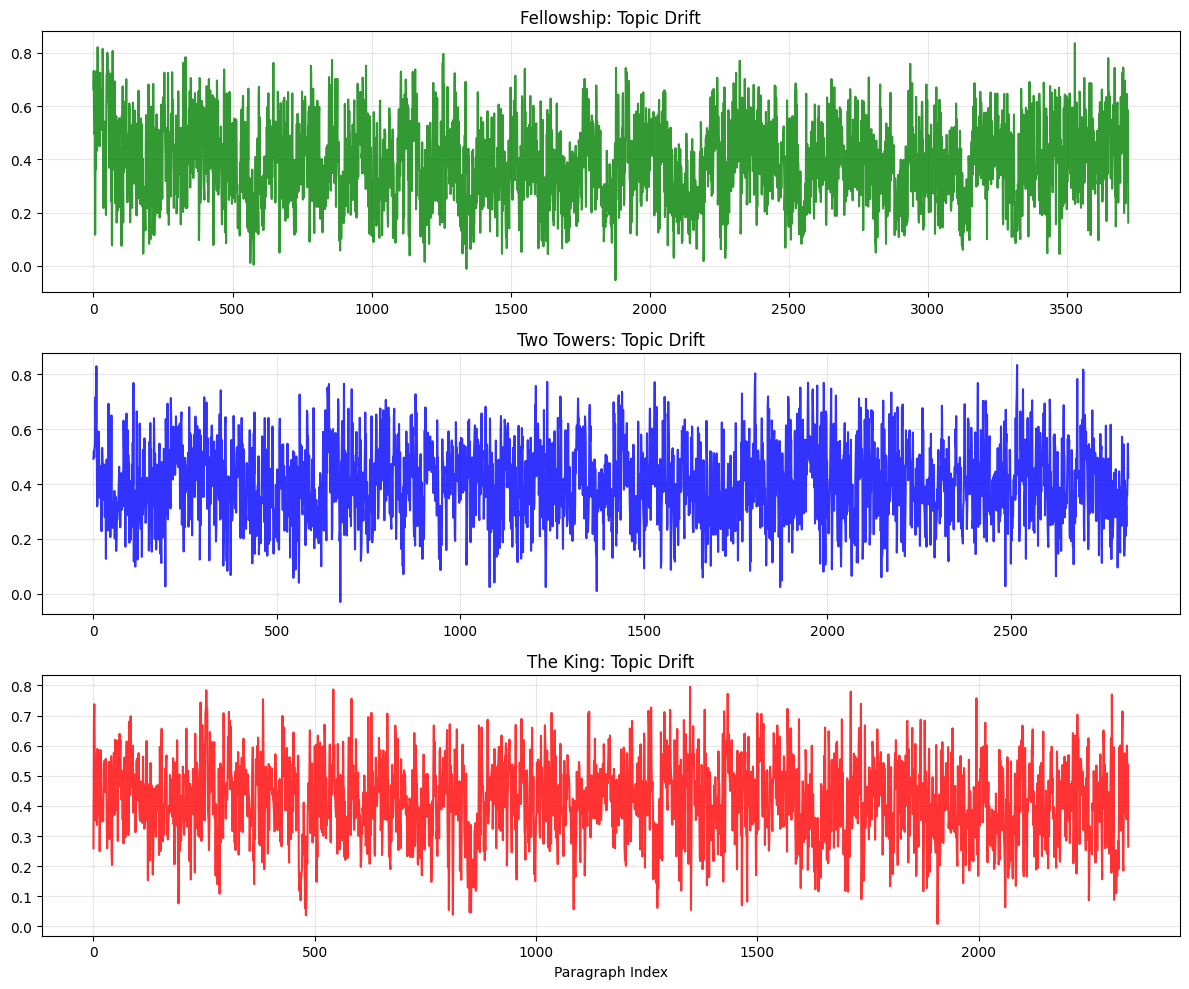

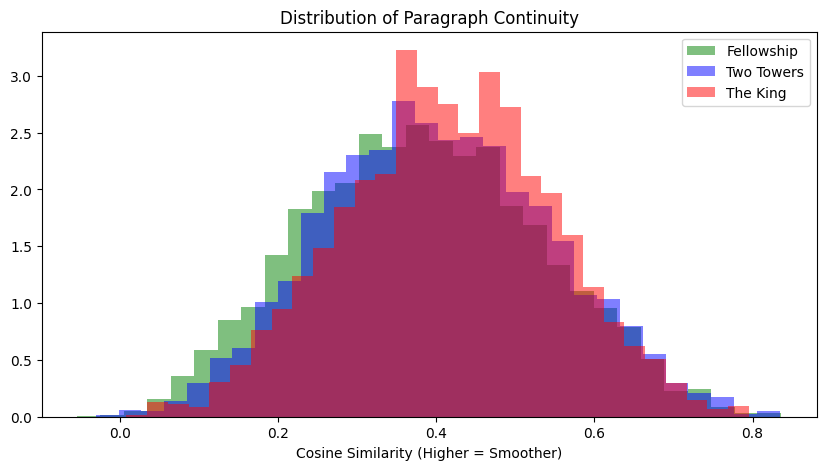

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

axes[0].plot(f_drift, alpha=0.8, color='green')
axes[0].set_title('Fellowship: Topic Drift')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_drift, alpha=0.8, color='blue')
axes[1].set_title('Two Towers: Topic Drift')
axes[1].grid(True, alpha=0.3)

axes[2].plot(k_drift, alpha=0.8, color='red')
axes[2].set_title('The King: Topic Drift')
axes[2].set_xlabel('Paragraph Index')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(f_drift, bins=30, alpha=0.5, label='Fellowship', density=True, color='green')
ax.hist(t_drift, bins=30, alpha=0.5, label='Two Towers', density=True, color='blue')
ax.hist(k_drift, bins=30, alpha=0.5, label='The King', density=True, color='red')
ax.set_title('Distribution of Paragraph Continuity')
ax.set_xlabel('Cosine Similarity (Higher = Smoother)')
ax.legend()
plt.show()

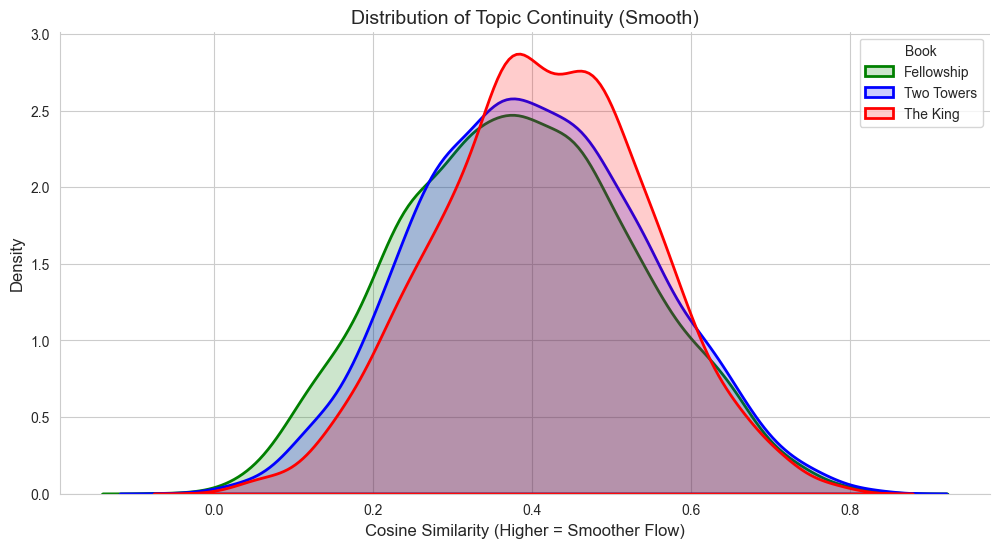

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Smooth Curves (KDE)
sns.kdeplot(f_drift, fill=True, color='green', label='Fellowship', alpha=0.2, linewidth=2, ax=ax)
sns.kdeplot(t_drift, fill=True, color='blue', label='Two Towers', alpha=0.2, linewidth=2, ax=ax)
sns.kdeplot(k_drift, fill=True, color='red', label='The King', alpha=0.2, linewidth=2, ax=ax)

ax.set_title('Distribution of Topic Continuity (Smooth)', fontsize=14)
ax.set_xlabel('Cosine Similarity (Higher = Smoother Flow)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(title='Book')

# Clean up the border
sns.despine()

plt.show()

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [ ]:
del fellowship_text, towers_text, king_text
del fellowship_paras, towers_paras, king_paras
del f_drift, t_drift, k_drift
del model
gc.collect()